# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958 

## Récupération des données 

Les données ont été téléchargées sur le [site Web de l'institut Scripps](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html), dans le fichier "`monthly_in_situ_c02_mlo.csv`".



In [16]:
import wget

# url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"
# wget.download(url, '.')


Formattons le fichier pour ne garder que les données, et non les commentaires (gardons les dans une variable, au cas où).
Nous allons ici créer un fichier `raw_data.csv` dans lequel nous stockons les données.


In [17]:
with open("monthly_in_situ_co2_mlo.csv", 'r') as data_file:
    lines = [line for line in data_file]

commentary = []
with open("raw_data.csv", 'w') as raw_data_file:
    for line in lines:
        if line.startswith('"'):
            commentary.append(lines)
        else:
            raw_data_file.write(line)

Chargeons donc les données avec pandas :

In [18]:
import pandas as pd

raw_dataframe = pd.read_csv("raw_data.csv", delimiter=', ', index_col=False)


/home/baptiste/Documents/venvs/develop/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


On va traiter le dataframe pour mettre en forme le header et vérifier les données.
Le dataframe ne comporte que 4 colonnes que nous allons utiliser :

* Years 
* Months
* CO2
* Seasonally adjusted

Les deux premières seront utilisées pour générer un tableau de dates qui serront des objets datetime, initialisés au premier jour de chacun des mois du dataset.

Les deux autres colonnes sont les données qui ont être utilisées pour le premier graphique. 

**CO2** contient les quantité brutes de CO2 relevées, et **seasonally adjusted** est le résultat d'un traitement de **CO2** pour retirer les variations saisonnières.

In [19]:

import matplotlib.pyplot as plt
import datetime
co2_raw_vals = raw_dataframe.iloc[2:, 4].astype(float)
co2_adjusted_vals = raw_dataframe.iloc[2:, 5].astype(float)
dates = [datetime.date(year=int(year), month=int(month), day=1) for year, month in zip(raw_dataframe.iloc[2:, 0], raw_dataframe.iloc[2:, 1])]

## Première analyse 

Pour réaliser le premier graphique montrant une oscillation périodique superposée à une évolution systématique plus lente, nous plottons tout d'abord les données brutes de la colonne **CO2** pour pouvoir distinguer les oscillations péridoques et la croissance lente systématique. 

Nous n'avons sélectionné que les 100 premiers points pour plus de lisibilité sur le graphique.

De plus, l'axe des ordonnées a été forcé entre 300 et 340 pour ne pas afficher les données manquantes, remplacées par des valeurs à -99.  

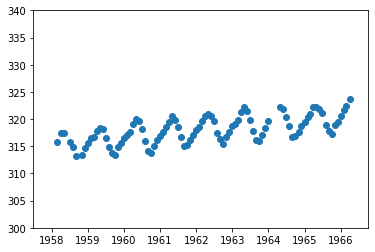

In [20]:
%matplotlib inline
fig, ax=plt.subplots(1)
ax.scatter(dates[:100], co2_raw_vals[:100])
lim = ax.set_ylim(300,340)

## Séparation des phénomènes

### Périodicité uniquement
 
Nous allons maintenant séparer la périodicité. Pour ce faire, il suffit de tracer la différence entre les données ajustées et le données brutes, car la correciton a pour but de gommer la périodicité.

De la même manière que précédemment, nous avons tracé que les 100 premiers points et nous avons adapté l'échelle des ordonnées pour plus de clarté visuelle.

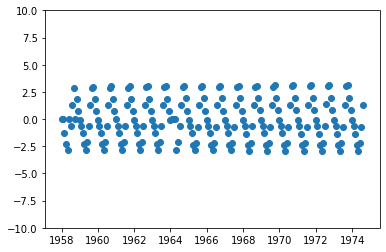

In [21]:
%matplotlib inline

fig, ax=plt.subplots(1)
ax.scatter(dates[:200], co2_adjusted_vals[:200]-co2_raw_vals[:200])
lim = ax.set_ylim(-10,10)

### Contribution lente uniquement 

Pour permettre de faire un modèle simple de la contribution lente jusqu'en 2025, il nous faut d'abord l'estimer avec une fonction. Pour ce faire, analysons le comportement de la contribution simple sur  toute la durée disponible : 

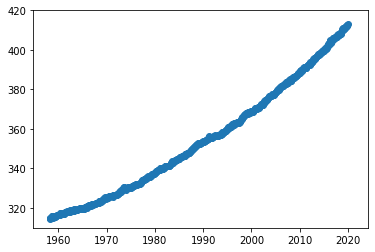

In [22]:
%matplotlib inline

fig, ax=plt.subplots(1)
ax.scatter(dates, co2_adjusted_vals)
lim = ax.set_ylim(310,420)

On peut voir sur ce graphe que la croissance n'est pas linéaire, on pourrait donc l'esitmer avec un polynome de degré 2.

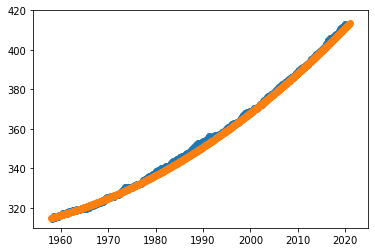

In [23]:
import numpy as np

a = 0.0001
b = 0.055
c = 315
xs = np.arange(len(dates))
ys = a*(xs**2)+b*xs+c

fig, ax=plt.subplots(1)
ax.scatter(dates, co2_adjusted_vals)
ax.scatter(dates, ys)
lim = ax.set_ylim(310,420)

En prenant une unité mensuelle, et avec le polynome $y = 0.0001 x^2 + 0.055 y + 315$, nous arrivons a générer un modèle qui représente bien la courbe de l'augmentation de CO2 pour la durée du dataset (ces valeurs ont été trouvé par methode trial and error). 
Selon notre modèle naif, la valeur de la quantité de C02 jusqu'en 2045 peut être extrapolée. Pour ce faire, nous allons générer tous les mois jusqu'en 2045 : 

In [24]:
dates_large = dates+[datetime.date(year=year+2021, month=month+1, day=1)  for year in range(25) for month in range(12)]

Puis appliquer la fonction d'extrapolation :

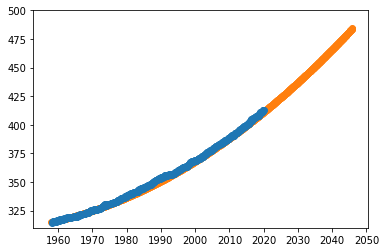

In [25]:
xs = np.arange(len(dates_large))
ys = a*(xs**2)+b*xs+c

fig, ax=plt.subplots(1)
ax.scatter(dates_large, ys, color="tab:orange")
ax.scatter(dates, co2_adjusted_vals, color="tab:blue")
lim = ax.set_ylim(310,500)